## Домашнее задание 

- обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

- при обучении моделей обязательно использовать кроссвалидацию
- вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

сделать выводы о том, какая модель справилась с задачей лучше других
(опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:

первая помечает 100 объектов как класс 1, но TP = 90
вторая помечает 1000 объектов как класс 1, но TP такой же - 90
Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

6. (опциональный вопрос) Найти порог классификации по деньгам (Стоимость лечения 15000 р, если сделали тест и начали лечить вовремя. Стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы. Стоимость теста 1400 р)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ, cardio - столбец) 

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [5]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [6]:
X_train.shape

(52500, 12)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [7]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [8]:
from sklearn.metrics import precision_recall_curve
def metrics_models(y_test, y_score): 
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(ix)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                    fscore[ix],
                                                                    precision[ix],
                                                                    recall[ix]))
    return thresholds[ix], fscore[ix], precision[ix], recall[ix]

In [9]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [10]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C = 0.1,random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=6, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7844374123135694+-0.005286474572634387


In [11]:
thresholds_lr, fscore_lr, precision_lr, recall_lr = metrics_models(y_test, y_score)

6196
Best Threshold=0.389193, F-Score=0.729, Precision=0.645, Recall=0.839


In [14]:
LR_parameters = [thresholds_lr, fscore_lr, precision_lr, recall_lr]

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
import random

In [16]:
random.seed(42)

In [17]:
classifier_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=7, random_state=42)),
])


#запустим кросс-валидацию
cv_scores_rf = cross_val_score(classifier_rf, X_train, y_train, cv=6, scoring='roc_auc')
cv_score_rf = np.mean(cv_scores_rf)
cv_score_std_rf = np.std(cv_scores_rf)
print('CV score is {}+-{}'.format(cv_score_rf, cv_score_std_rf))

#обучим пайплайн на всем тренировочном датасете
classifier_rf.fit(X_train, y_train)
y_score_rf = classifier_rf.predict_proba(X_test)[:, 1]

CV score is 0.7990276308201959+-0.004167008066728519


In [18]:
thresholds_rf, fscore_rf, precision_rf, recall_rf = metrics_models(y_test, y_score_rf)

5953
Best Threshold=0.381271, F-Score=0.739, Precision=0.666, Recall=0.830


In [20]:
RF_parameters = [thresholds_rf, fscore_rf, precision_rf, recall_rf]

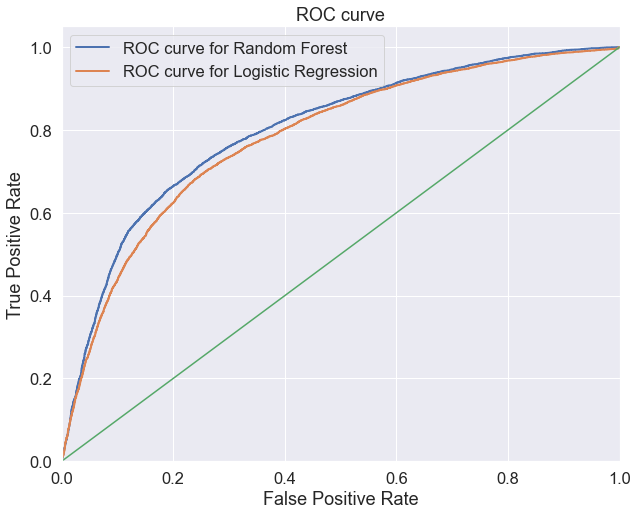

In [21]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_score_rf, pos_label=1)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_score, pos_label=1)
lw = 2

plt.plot(fpr_rf, tpr_rf, lw=lw, label='ROC curve for Random Forest')
plt.plot(fpr_lr, tpr_lr, lw=lw, label='ROC curve for Logistic Regression')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig("ROC.png")
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score

print("roc auc score for Random Forest: {}".format(roc_auc_score(y_test, y_score_rf)))
print("roc auc score for Logistic Regression: {}".format(roc_auc_score(y_test, y_score)))

roc auc score for Random Forest: 0.7994743173767203
roc auc score for Logistic Regression: 0.78198138395143


In [23]:
roc_auc_lr = roc_auc_score(y_test, y_score)

In [24]:
roc_auc_rf = roc_auc_score(y_test, y_score_rf)

In [25]:
RF_parameters.append(roc_auc_rf)
LR_parameters.append(roc_auc_lr)

In [74]:
result_gb = pd.read_csv('gb_data_classifier')

In [75]:
result_gb.head()

,gb_classifier
0,0.354076
1,0.737790
2,0.666729
3,0.825806
4,0.799478


In [76]:
result = pd.DataFrame(index = ['threshold', 'fscore', 'precision', 'recall', 'roc_auc'], 
                      columns = ['rf_classifier', 'lr_classifier'])

In [77]:
result['rf_classifier'] = RF_parameters 
result['lr_classifier'] = LR_parameters 

In [78]:
result.head()

,rf_classifier,lr_classifier
threshold,0.381271,0.389193
fscore,0.739434,0.728938
precision,0.666420,0.644507
recall,0.830415,0.838825
roc_auc,0.799474,0.781981


In [81]:
result['gb_classifier'] = result_gb.gb_classifier.to_list()

In [82]:
result.head()

,rf_classifier,lr_classifier,gb_classifier
threshold,0.381271,0.389193,0.354076
fscore,0.739434,0.728938,0.737790
precision,0.666420,0.644507,0.666729
recall,0.830415,0.838825,0.825806
roc_auc,0.799474,0.781981,0.799478


Выводы:

    - сложно сказать, какая модель лучше всего подойдет, потому что метрики не настолько сильно отличаются друг от друга
    
    - субъективно, я бы сперва отсек ту модель, у которой самый низкий порог, то есть Gradient Boosting. При увеличении количества данных мы можем столкнуться с увеличением FP, а это уже плохо.
    
    - далее нужно исходить из параметров precision\recall и целей бизнеса по ним. 

## Дополнительная задачка на определение "лучшести" модели

Если я правильно понял условие (обсудим на вебинаре), то я бы выбрал первую модель, потому что из 100 предсказаний первого класса у нас 90 является TP. 

У второй модели TP также будет 90 (по условию), но она отметила 1000 объектов классом 1. Доля правильных ответов у первой модели выше. 

Но согласно правилам, на несбалансированных данных как правило не оперируют accuracy. Поэтому я сомневаюсь в правильности своих рассуждений. 

Лично для меня было бы удобнее использовать [roc-auc кривую](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/)

Исходя главы "Смысл roc-auc кривой" я предполагаю, что у второй модели площадь кривой будет меньше, чем у первой. 
